In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


In [3]:
# Milestone 1: Data Collection, EDA, Preprocessing – Kaggle-Ready Single Cell
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)


In [4]:
# 1. Data Collection
sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')


Sales Info:
                 d_1           d_2           d_3           d_4           d_5  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       1.070220      1.041292      0.780026      0.833454      0.627944   
std        5.126689      5.365468      3.667454      4.415141      3.379344   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      360.000000    436.000000    207.000000    323.000000    296.000000   

                d_6           d_7           d_8           d_9          d_10  \
count  30490.000000  30490.000000  30490.000000  30490.000000  30490.000000   
mean       0.958052      0.918662      1.244080      1.073663      0.838701   
std        4.785947      5.059495     

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


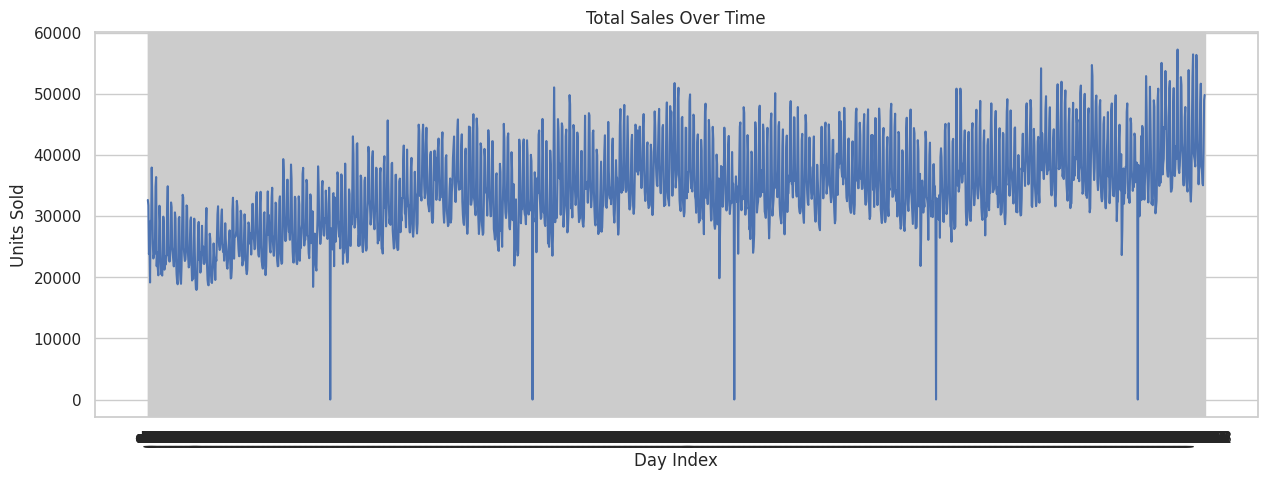

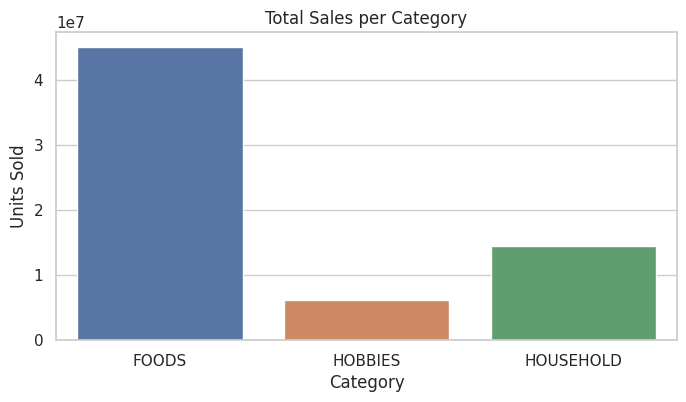

In [5]:
# 2. Exploratory Data Analysis (EDA)
print("Sales Info:\n", sales.describe())
print("Missing Values:", sales.isnull().sum().sum())
print("Duplicate Rows:", sales.duplicated().sum())

days = sales.columns[6:]
daily_sales = sales.iloc[:,6:].sum(axis=0)

plt.figure(figsize=(15,5))
sns.lineplot(data=daily_sales)
plt.title("Total Sales Over Time")
plt.xlabel("Day Index")
plt.ylabel("Units Sold")
plt.show()

sales_cat = sales.groupby('cat_id')[days].sum().sum(axis=1)
plt.figure(figsize=(8,4))
sns.barplot(x=sales_cat.index, y=sales_cat.values)
plt.title('Total Sales per Category')
plt.xlabel('Category')
plt.ylabel('Units Sold')
plt.show()

In [6]:
# 3. Preprocessing & Feature Engineering
calendar = calendar.ffill()
prices = prices.bfill()
Q1, Q3 = daily_sales.quantile(0.25), daily_sales.quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (daily_sales < Q1 - 1.5*IQR) | (daily_sales > Q3 + 1.5*IQR)
print("Number of outlier days:", outlier_mask.sum())

calendar["date"] = pd.to_datetime(calendar["date"])
calendar['is_weekend'] = calendar['weekday'].isin(['Saturday','Sunday']).astype(int)
calendar['is_holiday'] = calendar['event_name_1'].notnull().astype(int)

calendar_trim = calendar.iloc[:len(days)].copy()
calendar_trim.index = days
sales_days = sales[days]
sales_days.columns = calendar_trim['date']

sales_feat = sales.copy()
sales_feat['mean_sales'] = sales_days.mean(axis=1)
sales_feat['max_sales'] = sales_days.max(axis=1)
sales_feat['min_sales'] = sales_days.min(axis=1)
sales_feat['lag_30'] = sales_days.shift(30, axis=1).mean(axis=1)

cat_features = ['item_id','dept_id','store_id','cat_id','state_id']
encoded_feats = pd.get_dummies(sales[cat_features])
sales_feat = pd.concat([sales_feat, encoded_feats], axis=1)

num_cols = ['mean_sales','max_sales','min_sales','lag_30']
scaler = StandardScaler()
sales_feat[num_cols] = scaler.fit_transform(sales_feat[num_cols])

Number of outlier days: 19


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


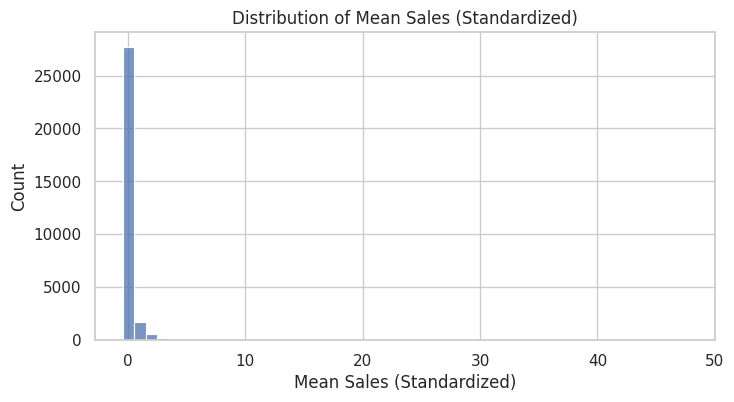

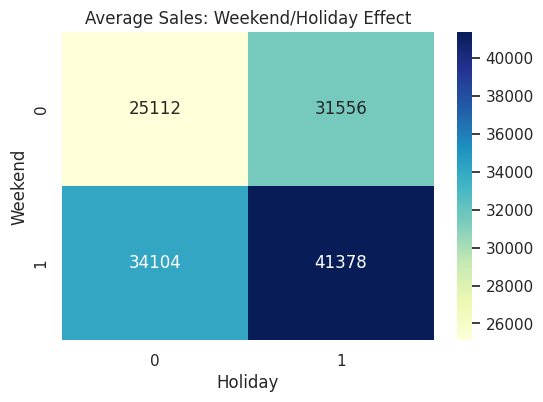

In [7]:
# 4. Visualizations
plt.figure(figsize=(8,4))
sns.histplot(sales_feat['mean_sales'], bins=50)
plt.title('Distribution of Mean Sales (Standardized)')
plt.xlabel('Mean Sales (Standardized)')
plt.ylabel('Count')
plt.show()

daily_sales_df = pd.DataFrame({'sales': daily_sales.values}, index=days)
joined = daily_sales_df.join(calendar_trim[['is_weekend','is_holiday']])
pivot = joined.pivot_table(index='is_weekend', columns='is_holiday', values='sales', aggfunc='mean')

plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Average Sales: Weekend/Holiday Effect')
plt.xlabel('Holiday')
plt.ylabel('Weekend')
plt.show()


In [8]:
# 5. Save Cleaned Dataset
sales_feat.to_csv('/kaggle/working/cleaned_sales_features.csv', index=False)
print("✅ Milestone 1 complete. Cleaned dataset saved as 'cleaned_sales_features.csv'. Ready for modeling!")

✅ Milestone 1 complete. Cleaned dataset saved as 'cleaned_sales_features.csv'. Ready for modeling!


In [9]:
# Milestone 2: Full Corrected Code – Advanced Analysis & Feature Engineering for Kaggle M5

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import plotly.express as px

In [10]:
# 1. Load cleaned data + original raw files as needed
sales_feat = pd.read_csv('/kaggle/working/cleaned_sales_features.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')

# ---- Prepare matching index ----
days = sales.columns[6:]  # 'd_1' to 'd_1913'
daily_sales = sales[days].sum(axis=0)
calendar_trim = calendar.iloc[:len(days)].copy()  # Only first 1913 rows (match sales columns)
calendar_trim.index = days
calendar_trim['sales'] = daily_sales.values

# ---- Add weekend and holiday flags ----
calendar_trim['is_weekend'] = calendar_trim['weekday'].isin(['Saturday', 'Sunday']).astype(int)
calendar_trim['is_holiday'] = calendar_trim['event_name_1'].notnull().astype(int)


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


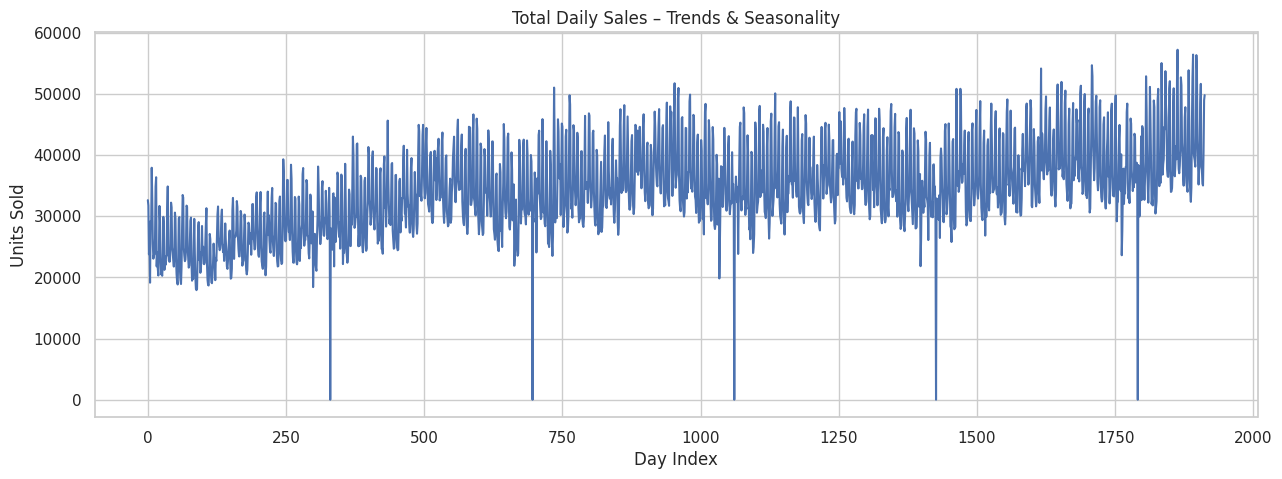

In [11]:
# 2. Advanced Data Analysis

# 2.1 Time Series Visualization
plt.figure(figsize=(15,5))
sns.lineplot(y=daily_sales.values, x=np.arange(len(daily_sales)))
plt.title("Total Daily Sales – Trends & Seasonality")
plt.xlabel("Day Index")
plt.ylabel("Units Sold")
plt.show()


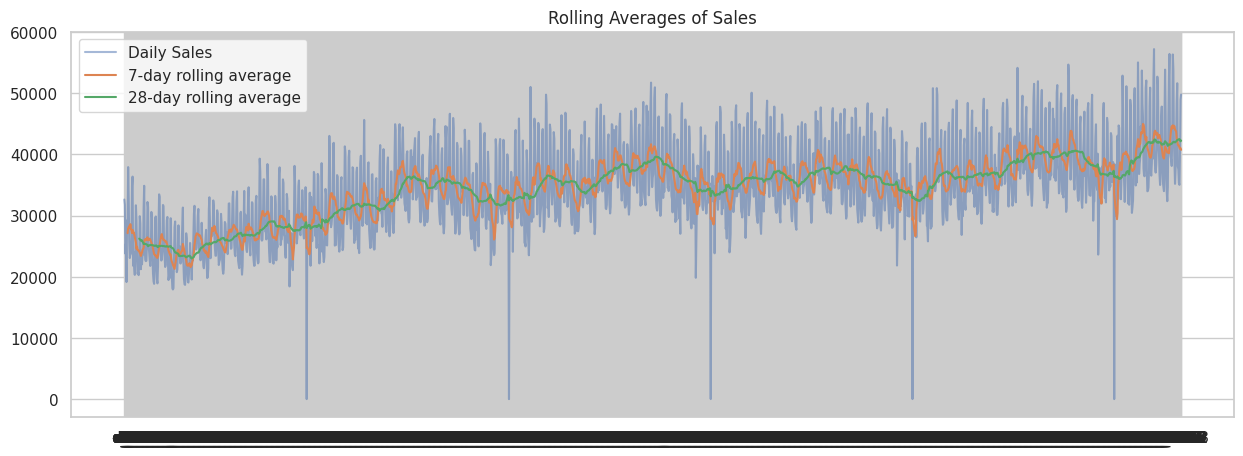

In [12]:
# 2.2 Rolling Average (7-day & 28-day)
rolling_7 = daily_sales.rolling(7).mean()
rolling_28 = daily_sales.rolling(28).mean()
plt.figure(figsize=(15,5))
plt.plot(daily_sales, label='Daily Sales', alpha=0.5)
plt.plot(rolling_7, label='7-day rolling average')
plt.plot(rolling_28, label='28-day rolling average')
plt.title("Rolling Averages of Sales")
plt.legend()
plt.show()

In [13]:
# 2.3 ADF test (stationarity)
adf_result = adfuller(daily_sales)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
if adf_result[1] < 0.05:
    print("Stationary: You can use ARIMA directly")
else:
    print("Non-Stationary: Consider differencing or other transformations")


ADF Statistic: -1.565373325331854
p-value: 0.5009604361797707
Non-Stationary: Consider differencing or other transformations


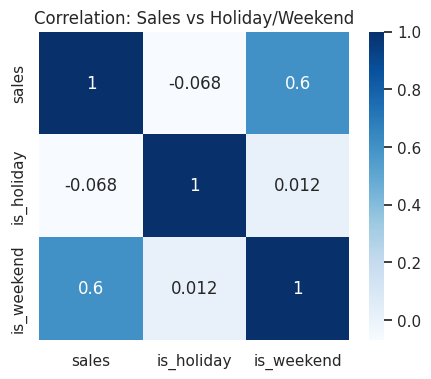

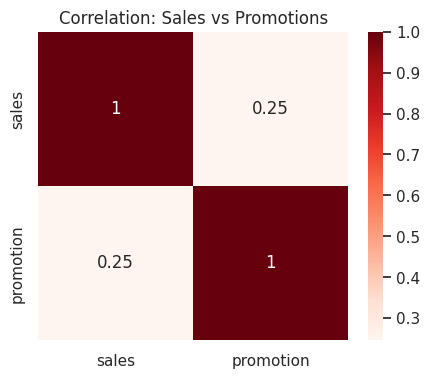

In [14]:
# 2.4 Correlation Analysis
corr = calendar_trim[['sales', 'is_holiday', 'is_weekend']].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title('Correlation: Sales vs Holiday/Weekend')
plt.show()

# Promotion flag example (if snap_CA exists)
if 'snap_CA' in calendar_trim.columns:
    calendar_trim['promotion'] = calendar_trim[['snap_CA','snap_TX','snap_WI']].any(axis=1).astype(int)
    corr_prom = calendar_trim[['sales', 'promotion']].corr()
    plt.figure(figsize=(5,4))
    sns.heatmap(corr_prom, annot=True, cmap="Reds")
    plt.title('Correlation: Sales vs Promotions')
    plt.show()


In [15]:
# 3. Advanced Feature Engineering

# 3.1 Rolling averages & lags
sales_days = sales[days]
sales_feat['rolling_7'] = sales_days.T.rolling(7).mean().T.mean(axis=1)
sales_feat['rolling_28'] = sales_days.T.rolling(28).mean().T.mean(axis=1)
sales_feat['lag_84'] = sales_days.shift(periods=84, axis=1).mean(axis=1)  # approx. quarterly lag


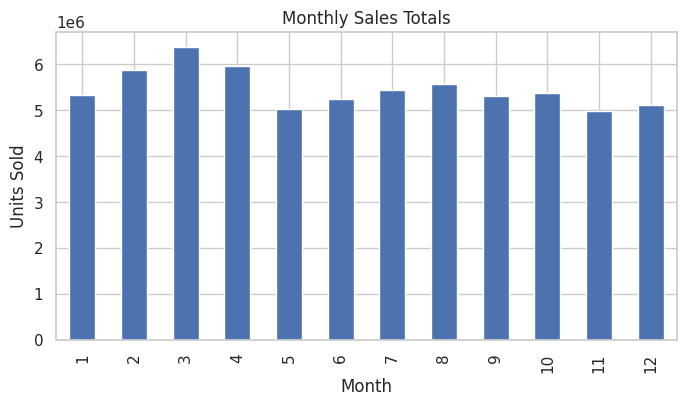

/tmp/ipykernel_38/2423551264.py:13: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sales_feat['monthly_sales_avg'] = sales_days.groupby(month_cols, axis=1).mean().mean(axis=1)


In [16]:
# 3.2 Aggregation: Monthly Sales Totals
calendar_trim['month'] = pd.to_datetime(calendar_trim['date']).dt.month
monthly_sales = daily_sales.groupby(calendar_trim['month']).sum()
plt.figure(figsize=(8,4))
monthly_sales.plot(kind='bar')
plt.title('Monthly Sales Totals')
plt.xlabel("Month")
plt.ylabel("Units Sold")
plt.show()

month_map = dict(zip(calendar_trim.index, calendar_trim['month']))
month_cols = [month_map[d] for d in days]
sales_feat['monthly_sales_avg'] = sales_days.groupby(month_cols, axis=1).mean().mean(axis=1)


In [17]:
# 3.3 Scaling
scaler = MinMaxScaler()
for col in ['rolling_7', 'rolling_28', 'lag_30', 'lag_84', 'monthly_sales_avg']:
    sales_feat[col] = scaler.fit_transform(sales_feat[[col]])


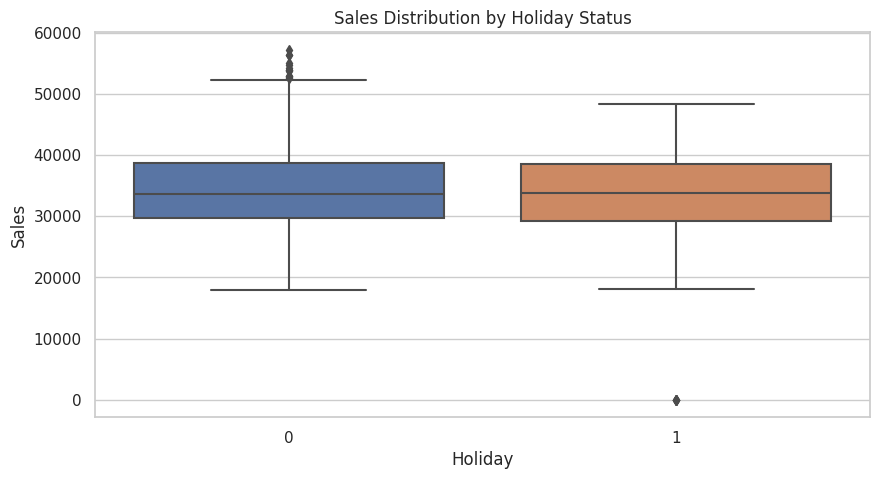

In [18]:
# 4. Data Visualization

# 4.1 Holiday Effect Visualization
plt.figure(figsize=(10,5))
sns.boxplot(x='is_holiday', y='sales', data=calendar_trim)
plt.title("Sales Distribution by Holiday Status")
plt.xlabel("Holiday")
plt.ylabel("Sales")
plt.show()


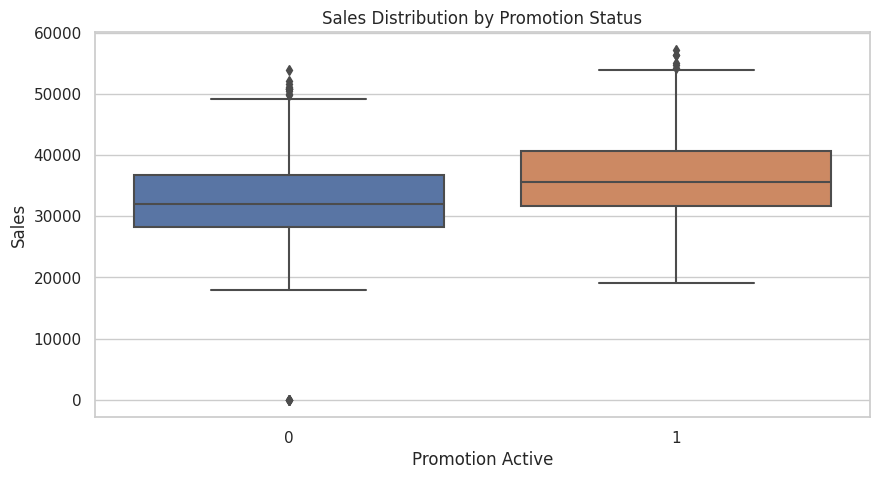

In [19]:
# 4.2 Promotion Effect Visualization (if exists)
if 'promotion' in calendar_trim.columns:
    plt.figure(figsize=(10,5))
    sns.boxplot(x='promotion', y='sales', data=calendar_trim)
    plt.title("Sales Distribution by Promotion Status")
    plt.xlabel("Promotion Active")
    plt.ylabel("Sales")
    plt.show()

In [20]:
# 4.3 Seasonal Patterns – Interactive Plot
fig = px.line(calendar_trim.reset_index(), x='date', y='sales', color='is_holiday',
              title='Sales Over Time by Holiday Effect')
fig.show()


In [21]:
# 5. Save Enhanced Features
sales_feat.to_csv('/kaggle/working/sales_enhanced_features.csv', index=False)
print("✅ Milestone 2 complete. Enhanced features and analysis saved!")

✅ Milestone 2 complete. Enhanced features and analysis saved!


In [24]:
# Milestone 1 + 2: Load raw data, preprocess, feature engineer, and save CSV

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Load raw data
sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
calendar = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/calendar.csv')
prices = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sell_prices.csv')

# Preprocessing & Feature Engineering
days = sales.columns[6:]
daily_sales = sales[days].sum(axis=0)

# Example features
sales_feat = sales.copy()
sales_feat['mean_sales'] = sales[days].mean(axis=1)
sales_feat['max_sales'] = sales[days].max(axis=1)
sales_feat['min_sales'] = sales[days].min(axis=1)
sales_feat['lag_30'] = sales[days].shift(30, axis=1).mean(axis=1)

cat_features = ['item_id','dept_id','store_id','cat_id','state_id']
sales_feat = pd.get_dummies(sales_feat, columns=cat_features)

# Scale numeric features
num_cols = ['mean_sales','max_sales','min_sales','lag_30']
scaler = MinMaxScaler()
sales_feat[num_cols] = scaler.fit_transform(sales_feat[num_cols])

# Save for Milestone 3
sales_feat.to_csv('/kaggle/working/sales_feature_engineered.csv', index=False)
print("✅ Feature engineered CSV saved: sales_feature_engineered.csv")


✅ Feature engineered CSV saved: sales_feature_engineered.csv


In [26]:
# Milestone 3: Consistent Machine Learning & Time Series Forecasting Pipeline
# All models predict the same target: next 30-day total sales per item

import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import joblib
import warnings
warnings.filterwarnings("ignore")

# TensorFlow for LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [28]:
print(features_data.columns.tolist())


['id', 'd_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10', 'd_11', 'd_12', 'd_13', 'd_14', 'd_15', 'd_16', 'd_17', 'd_18', 'd_19', 'd_20', 'd_21', 'd_22', 'd_23', 'd_24', 'd_25', 'd_26', 'd_27', 'd_28', 'd_29', 'd_30', 'd_31', 'd_32', 'd_33', 'd_34', 'd_35', 'd_36', 'd_37', 'd_38', 'd_39', 'd_40', 'd_41', 'd_42', 'd_43', 'd_44', 'd_45', 'd_46', 'd_47', 'd_48', 'd_49', 'd_50', 'd_51', 'd_52', 'd_53', 'd_54', 'd_55', 'd_56', 'd_57', 'd_58', 'd_59', 'd_60', 'd_61', 'd_62', 'd_63', 'd_64', 'd_65', 'd_66', 'd_67', 'd_68', 'd_69', 'd_70', 'd_71', 'd_72', 'd_73', 'd_74', 'd_75', 'd_76', 'd_77', 'd_78', 'd_79', 'd_80', 'd_81', 'd_82', 'd_83', 'd_84', 'd_85', 'd_86', 'd_87', 'd_88', 'd_89', 'd_90', 'd_91', 'd_92', 'd_93', 'd_94', 'd_95', 'd_96', 'd_97', 'd_98', 'd_99', 'd_100', 'd_101', 'd_102', 'd_103', 'd_104', 'd_105', 'd_106', 'd_107', 'd_108', 'd_109', 'd_110', 'd_111', 'd_112', 'd_113', 'd_114', 'd_115', 'd_116', 'd_117', 'd_118', 'd_119', 'd_120', 'd_121', 'd_122', 'd_

In [31]:
X = features_data.drop(columns=['id', 'sales_30d'])
y = features_data['sales_30d']


In [32]:
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]


In [33]:
# ------------------------------
# 1. Load cleaned features + raw sales
# ------------------------------
features_data = pd.read_csv('/kaggle/working/sales_enhanced_features.csv')
raw_sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
days = raw_sales.columns[6:]  # 'd_1' to 'd_1913'


In [34]:
# ------------------------------
# 2. Prepare target (sum of next 30 days)
# ------------------------------
target_window = 30
features_data['sales_30d'] = raw_sales[days[-target_window:]].sum(axis=1)


In [35]:
# ------------------------------
# 3. Prepare features (drop only columns that exist)
# ------------------------------
exclude_cols = ['id', 'sales_30d']  # Keep all one-hot encoded categorical features
X = features_data.drop(columns=[col for col in exclude_cols if col in features_data.columns])
y = features_data['sales_30d']

In [37]:
# Train/test split (80/20)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [39]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns


In [40]:
from sklearn.preprocessing import LabelEncoder

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [42]:
# ------------------------------
# 4. Machine Learning Models
# ------------------------------
# Random Forest
rf = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [43]:
# Gradient Boosting
gb = GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)


In [44]:
# Evaluation function
def evaluate(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} -> MAE: {mae:.3f} | MSE: {mse:.3f} | RMSE: {rmse:.3f} | R2: {r2:.3f}")
    
evaluate(y_test, y_pred_rf, "Random Forest")
evaluate(y_test, y_pred_gb, "Gradient Boosting")

Random Forest -> MAE: 7.874 | MSE: 681.729 | RMSE: 26.110 | R2: 0.945
Gradient Boosting -> MAE: 4.013 | MSE: 328.918 | RMSE: 18.136 | R2: 0.973


In [45]:
# ------------------------------
# 5. Time Series Models (ARIMA, ETS)
# ------------------------------
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Aggregate daily sales
daily_sales = raw_sales[days].sum()
split_pt = int(0.8 * len(daily_sales))
train_series = daily_sales.iloc[:split_pt]
test_series = daily_sales.iloc[split_pt:]

# ARIMA
arima_model = ARIMA(train_series, order=(2,1,2)).fit()
forecast_arima = arima_model.forecast(len(test_series))
evaluate(test_series, forecast_arima, "ARIMA")

# ETS
ets_model = ExponentialSmoothing(train_series, trend='add', seasonal='add', seasonal_periods=7).fit()
forecast_ets = ets_model.forecast(len(test_series))
evaluate(test_series, forecast_ets, "ETS")

ARIMA -> MAE: 5246.890 | MSE: 51272877.010 | RMSE: 7160.508 | R2: -0.159
ETS -> MAE: 2790.586 | MSE: 16544306.969 | RMSE: 4067.469 | R2: 0.626


In [46]:
# ------------------------------
# 6. LSTM Neural Network
# ------------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Scale daily sales
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(np.array(daily_sales).reshape(-1,1))

# Create sequences
def create_sequences(data, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(data)-seq_length-1):
        X_seq.append(data[i:i+seq_length,0])
        y_seq.append(data[i+seq_length,0])
    return np.array(X_seq), np.array(y_seq)

seq_length = 30
X_lstm, y_lstm = create_sequences(sales_scaled, seq_length)
split_lstm = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split_lstm], X_lstm[split_lstm:]
y_train_lstm, y_test_lstm = y_lstm[:split_lstm], y_lstm[split_lstm:]

# Reshape for LSTM [samples, timesteps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1],1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1],1))

# Build LSTM model
lstm_model = Sequential([
    LSTM(32, input_shape=(seq_length,1)),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=1)

# Predict & inverse scale
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm_inv = scaler.inverse_transform(y_pred_lstm)
y_test_lstm_inv = scaler.inverse_transform(y_test_lstm.reshape(-1,1))
evaluate(y_test_lstm_inv, y_pred_lstm_inv, "LSTM")


I0000 00:00:1764502927.685801      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764502927.686352      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/10


I0000 00:00:1764502930.959243     178 cuda_dnn.cc:529] Loaded cuDNN version 90300


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1422
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0099
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM -> MAE: 5245.562 | MSE: 50732343.742 | RMSE: 7122.664 | R2: -0.146


In [47]:
# ------------------------------
# 7. Compare Models & Save Best ML Model
# ------------------------------
mse_results = {
    'Random Forest': mean_squared_error(y_test, y_pred_rf),
    'Gradient Boosting': mean_squared_error(y_test, y_pred_gb),
    'ARIMA': mean_squared_error(test_series, forecast_arima),
    'ETS': mean_squared_error(test_series, forecast_ets),
    'LSTM': mean_squared_error(y_test_lstm_inv, y_pred_lstm_inv)
}

best_model_name = min(mse_results, key=mse_results.get)
print("\nBest Model Based on MSE:", best_model_name)

# Save ML models
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    final_model = rf if best_model_name=='Random Forest' else gb
    joblib.dump(final_model, '/kaggle/working/final_sales_model.pkl')
    print(f"✅ Best ML model saved at /kaggle/working/final_sales_model.pkl")
else:
    print("Best model is time series or LSTM. Consider saving model object manually if needed.")


Best Model Based on MSE: Gradient Boosting
✅ Best ML model saved at /kaggle/working/final_sales_model.pkl


<Figure size 1200x600 with 0 Axes>

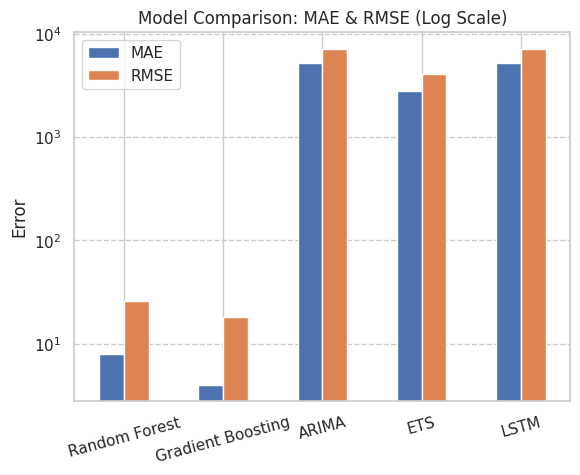

<Figure size 700x400 with 0 Axes>

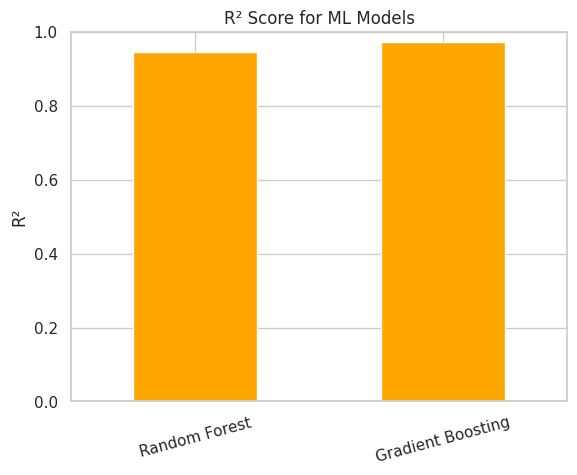

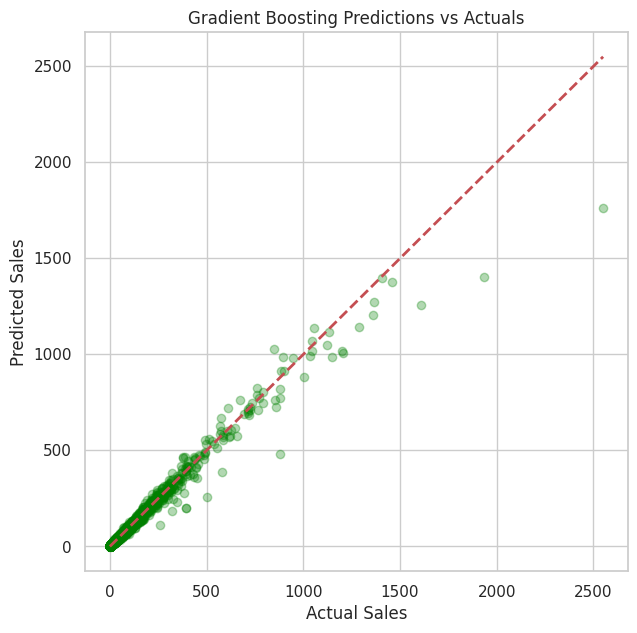

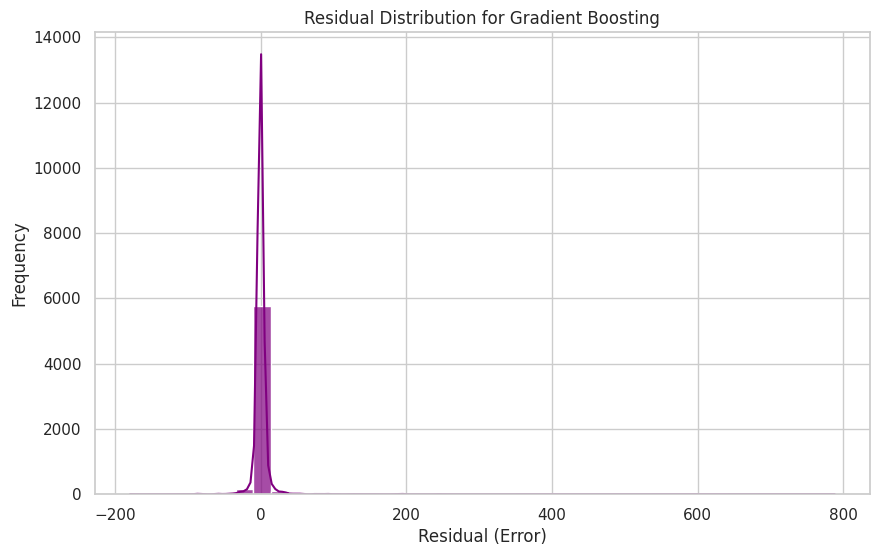

✅ Model evaluation visualizations complete!


In [49]:
# ------------------------------
# 8. Model Evaluation Visualizations
# ------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Store evaluation metrics for visualization
results = {
    "Random Forest": {"MAE": mean_absolute_error(y_test, y_pred_rf),
                      "MSE": mean_squared_error(y_test, y_pred_rf),
                      "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_rf)),
                      "R2": r2_score(y_test, y_pred_rf)},
    
    "Gradient Boosting": {"MAE": mean_absolute_error(y_test, y_pred_gb),
                          "MSE": mean_squared_error(y_test, y_pred_gb),
                          "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_gb)),
                          "R2": r2_score(y_test, y_pred_gb)},
    
    "ARIMA": {"MAE": mean_absolute_error(test_series, forecast_arima),
              "MSE": mean_squared_error(test_series, forecast_arima),
              "RMSE": np.sqrt(mean_squared_error(test_series, forecast_arima))},
    
    "ETS": {"MAE": mean_absolute_error(test_series, forecast_ets),
            "MSE": mean_squared_error(test_series, forecast_ets),
            "RMSE": np.sqrt(mean_squared_error(test_series, forecast_ets))},
    
    "LSTM": {"MAE": mean_absolute_error(y_test_lstm_inv, y_pred_lstm_inv),
             "MSE": mean_squared_error(y_test_lstm_inv, y_pred_lstm_inv),
             "RMSE": np.sqrt(mean_squared_error(y_test_lstm_inv, y_pred_lstm_inv))}
}

df_results = pd.DataFrame(results).T

# --- 1. MAE & RMSE Bar Chart ---
plt.figure(figsize=(12,6))
df_results[['MAE','RMSE']].plot(kind='bar', logy=True)
plt.title('Model Comparison: MAE & RMSE (Log Scale)')
plt.ylabel('Error')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--')
plt.show()

# --- 2. R² Score for ML Models ---
ml_r2 = df_results[['R2']].dropna()
plt.figure(figsize=(7,4))
ml_r2.plot(kind='bar', color='orange', legend=False)
plt.title('R² Score for ML Models')
plt.ylabel('R²')
plt.ylim(0,1)
plt.xticks(rotation=15)
plt.show()

# --- 3. Predicted vs Actual Scatter Plot (Best ML Model) ---
import numpy as np

if best_model_name == "Random Forest":
    y_best = y_pred_rf
elif best_model_name == "Gradient Boosting":
    y_best = y_pred_gb
elif best_model_name == "ARIMA":
    y_best = forecast_arima
elif best_model_name == "ETS":
    y_best = forecast_ets
else:
    y_best = y_pred_lstm_inv.flatten()
    y_test_plot = y_test_lstm_inv.flatten()

plt.figure(figsize=(7,7))
plt.scatter(y_test if best_model_name not in ['LSTM'] else y_test_plot,
            y_best, alpha=0.3, color='green')
plt.plot([0, max(y_best.max(), (y_test.max() if best_model_name not in ['LSTM'] else y_test_plot.max()))],
         [0, max(y_best.max(), (y_test.max() if best_model_name not in ['LSTM'] else y_test_plot.max()))],
         'r--', linewidth=2)
plt.title(f"{best_model_name} Predictions vs Actuals")
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.grid(True)
plt.show()

# --- 4. Residual Distribution ---
residuals = (y_test if best_model_name not in ['LSTM'] else y_test_plot) - y_best
plt.figure(figsize=(10,6))
sns.histplot(residuals, bins=40, kde=True, color='purple', alpha=0.7)
plt.title(f"Residual Distribution for {best_model_name}")
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print("✅ Model evaluation visualizations complete!")


In [55]:
import tensorflow as tf
print(tf.__version__)  # should be 2.18.0


2.18.0


In [56]:
!pip install mlflow --upgrade-strategy only-if-needed


In [58]:
# Create a virtual environment (Linux/Mac)
!python -m venv mlops_env

# Activate virtual environment (Linux/Mac)
# Note: Activation won't work inside a notebook cell; it's for terminal only
# So for notebooks, just install packages directly:
!pip install mlflow fastapi uvicorn


Error: Command '['/kaggle/working/mlops_env/bin/python3', '-m', 'ensurepip', '--upgrade', '--default-pip']' returned non-zero exit status 1.


In [59]:
# Install MLflow, FastAPI, Uvicorn, and joblib
!pip install mlflow fastapi uvicorn joblib nest-asyncio pyngrok --quiet


In [60]:
import joblib

# Load the best ML model (Random Forest or Gradient Boosting)
model_path = '/kaggle/working/final_sales_model.pkl'
model = joblib.load(model_path)

print("✅ Model loaded successfully!")


✅ Model loaded successfully!


✅ Evaluation Metrics:
MAE: 4.013 | MSE: 328.918 | R2: 0.973
✅ Metrics logged (simulate MLflow) at metrics_log.json

Demo API predictions for 5 samples:
[ 6.3365282  17.92379606  6.73947868 14.33764083 21.8991153 ]


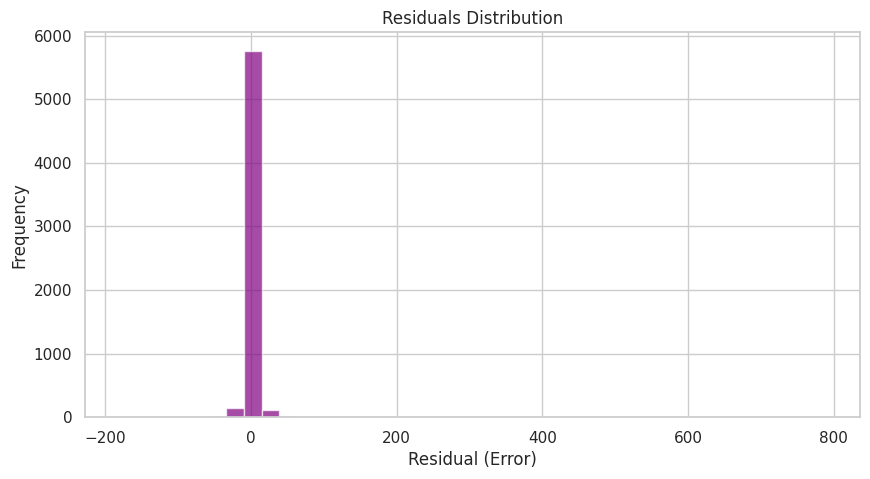

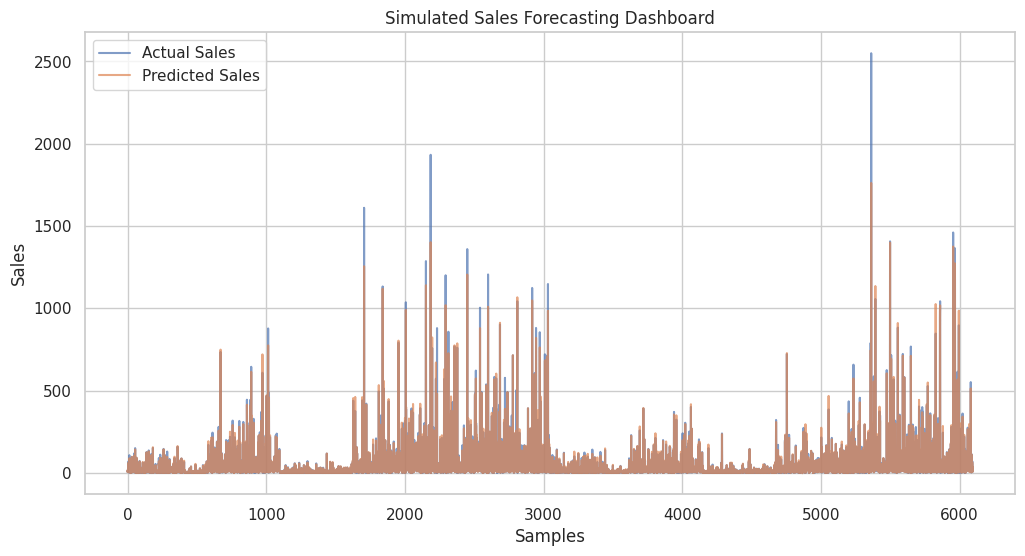

✅ Milestone 4 simulation complete!


In [66]:
# ==============================
# Milestone 4: MLOps Simulation on Kaggle
# ==============================

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

# ------------------------------
# 1. Load Model & Data
# ------------------------------
# Load best ML model (example: Gradient Boosting)
model_path = "/kaggle/working/final_sales_model.pkl"
model = joblib.load(model_path)

# Load features
features_data = pd.read_csv('/kaggle/working/sales_enhanced_features.csv')
raw_sales = pd.read_csv('/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv')
days = raw_sales.columns[6:]

target_window = 30
features_data['sales_30d'] = raw_sales[days[-target_window:]].sum(axis=1)

exclude_cols = ['id', 'sales_30d']
X = features_data.drop(columns=[col for col in exclude_cols if col in features_data.columns])
y = features_data['sales_30d']

# ------------------------------
# 2. Encode categorical features
# ------------------------------
from sklearn.preprocessing import LabelEncoder
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Split for evaluation (simulate test)
split_idx = int(0.8 * len(X))
X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]

# ------------------------------
# 3. Predict & Evaluate
# ------------------------------
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"✅ Evaluation Metrics:\nMAE: {mae:.3f} | MSE: {mse:.3f} | R2: {r2:.3f}")

# ------------------------------
# 4. Log Metrics (simulate MLflow)
# ------------------------------
metrics = {
    "model_type": type(model).__name__,
    "MAE": mae,
    "MSE": mse,
    "R2": r2
}

with open("/kaggle/working/metrics_log.json", "w") as f:
    json.dump(metrics, f)

print("✅ Metrics logged (simulate MLflow) at metrics_log.json")

# ------------------------------
# 5. Simulate API Deployment
# ------------------------------
def predict_sales(features_df):
    """
    Simulate deployment: takes a feature DataFrame and returns predicted sales
    """
    # Encode categorical
    for col in categorical_cols:
        if col in features_df.columns:
            le = LabelEncoder()
            features_df[col] = le.fit_transform(features_df[col])
    return model.predict(features_df)

# Demo API call
demo_input = X_test.head(5)
demo_output = predict_sales(demo_input)
print("\nDemo API predictions for 5 samples:")
print(demo_output)

# ------------------------------
# 6. Monitoring & Alerts
# ------------------------------
# Residuals plot
residuals = y_test - y_pred
plt.figure(figsize=(10,5))
plt.hist(residuals, bins=40, color='purple', alpha=0.7)
plt.title("Residuals Distribution")
plt.xlabel("Residual (Error)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Alert if performance drops (simulated)
threshold_mae = 50
if mae > threshold_mae:
    print(f"⚠️ Alert: MAE {mae:.2f} exceeds threshold of {threshold_mae}")

# ------------------------------
# 7. Dashboard Visual (Predicted vs Actual)
# ------------------------------
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual Sales", alpha=0.7)
plt.plot(y_pred, label="Predicted Sales", alpha=0.7)
plt.title("Simulated Sales Forecasting Dashboard")
plt.xlabel("Samples")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

print("✅ Milestone 4 simulation complete!")
